## Training YOLOv5 for 10 epochs to demonstrate detection of car license plates

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import os 
import shutil
from tqdm import tqdm
import yaml
import matplotlib.pyplot as plt 
import torch
import cv2
from glob import glob
import pytesseract as pt 

In [2]:
filenames = []

size_props = {
    'height':[],
    'width':[]
}

bounding_box_props = {
    'xmin':[],
    'ymin':[],
    'xmax':[],
    'ymax':[]
}

In [3]:
annotations_path = '../input/car-plate-detection/annotations'
for file in tqdm(os.listdir(annotations_path)):
    annotation = ET.parse(os.path.join(annotations_path, file))
    filenames.append(os.path.join(annotations_path, file))
    size = annotation.find('size')
    for name, prop_list in size_props.items():
        prop_value = size.find(name).text
        size_props[name].append(int(prop_value))
    bounding_box = annotation.find('object').find('bndbox')
    for name, prop_list in bounding_box_props.items():
        prop_value = bounding_box.find(name).text
        bounding_box_props[name].append(int(prop_value))

100%|██████████| 433/433 [00:01<00:00, 241.46it/s]


In [4]:
df = pd.DataFrame({
    'file':filenames,
    'width':size_props['width'],
    'height':size_props['height'],
    'xmin':bounding_box_props['xmin'],
    'ymin':bounding_box_props['ymin'],
    'xmax':bounding_box_props['xmax'],
    'ymax':bounding_box_props['ymax']
})

In [5]:
df.head()

,file,width,height,xmin,ymin,xmax,ymax
0,../input/car-plate-detection/annotations/Cars3...,500,300,209,135,283,169
1,../input/car-plate-detection/annotations/Cars1...,400,268,191,147,242,169
2,../input/car-plate-detection/annotations/Cars7...,400,267,115,115,277,153
3,../input/car-plate-detection/annotations/Cars1...,400,221,36,175,62,186
4,../input/car-plate-detection/annotations/Cars2...,517,303,71,205,215,246


In [6]:
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']

In [7]:
df.head()

,file,width,height,xmin,ymin,xmax,ymax,center_x,center_y,bb_width,bb_height
0,../input/car-plate-detection/annotations/Cars3...,500,300,209,135,283,169,0.492000,0.506667,0.14800,0.113333
1,../input/car-plate-detection/annotations/Cars1...,400,268,191,147,242,169,0.541250,0.589552,0.12750,0.082090
2,../input/car-plate-detection/annotations/Cars7...,400,267,115,115,277,153,0.490000,0.501873,0.40500,0.142322
3,../input/car-plate-detection/annotations/Cars1...,400,221,36,175,62,186,0.122500,0.816742,0.06500,0.049774
4,../input/car-plate-detection/annotations/Cars2...,517,303,71,205,215,246,0.276596,0.744224,0.27853,0.135314


In [8]:
yolo_df = df[['file', 'center_x', 'center_y', 'bb_width', 'bb_height']]
df_train, df_test = train_test_split(yolo_df, test_size=0.2)

In [9]:
train_path = os.path.join('Images', 'train')
test_path = os.path.join('Images', 'test')
images_path = '../input/car-plate-detection/images'

if not os.path.exists(train_path):
    os.makedirs(train_path)
    print('Made folder for train set')
if not os.path.exists(test_path):
    os.makedirs(test_path)
    print('Made folder for test set')

Made folder for train set
Made folder for test set


In [10]:
for _, row  in tqdm(df_train.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.png')
    image_dst = os.path.join(train_path, f'{image_name}.png')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(train_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)

346it [00:05, 63.39it/s]


In [11]:
for _, row  in tqdm(df_test.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.png')
    image_dst = os.path.join(test_path, f'{image_name}.png')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(test_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)

87it [00:01, 80.33it/s]


### Trained Dataset and retrieved the results in working directory

In [12]:
! git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 13071, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 13071 (delta 154), reused 205 (delta 123), pack-reused 12825
Receiving objects: 100% (13071/13071), 12.47 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (8980/8980), done.


In [13]:
! pip install -r yolov5/requirements.txt

In [14]:
data = {
    'names':['License Plate'],
    'nc':1,
    'train':os.path.abspath(train_path),
    'val':os.path.abspath(test_path)
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f)

In [15]:
!python ./yolov5/train.py --data ./data.yaml  --batch-size 8  --epochs 10 --weights yolov5/yolov5s.pt

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5/yolov5s.pt, cfg=, data=./data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-316-g916bdb1 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01,

In [16]:
yolo_path = '/kaggle/working/yolov5/runs/train/'
latest_run = os.listdir(yolo_path)[-1]

In [17]:
best_weights = os.path.join(yolo_path, latest_run, 'weights', 'best.pt')

In [18]:
model = torch.hub.load('ultralytics/yolov5', 'custom', best_weights)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-7-24 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [19]:
test_images = [file for file in glob('Images/test/*.png')]

In [20]:
test_images = np.random.choice(test_images, size=16).reshape(4,4)

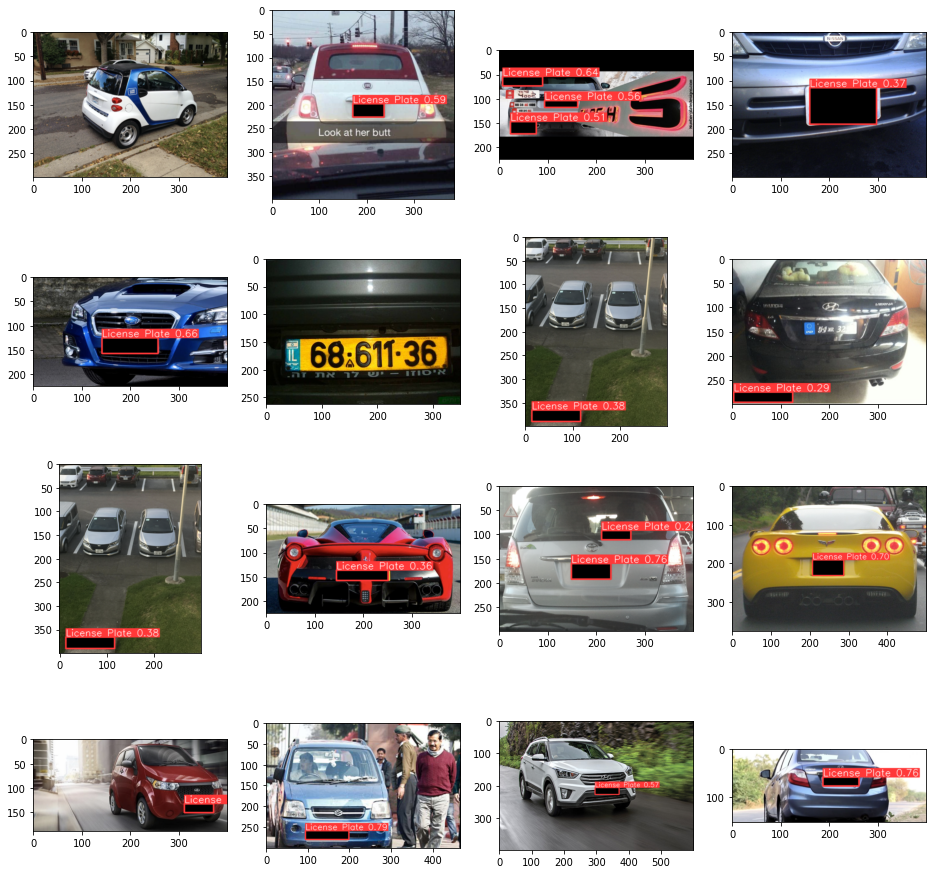

In [21]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,16), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        image = cv2.imread(test_images[i,j])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = model(image)
        try:
            k,f = 0,0
            while f == 0:
                try:
                    results_df = results.pandas().xyxy[0].loc[k]
                    x_min = int(results_df['xmin'])
                    x_max = int(results_df['xmax'])
                    y_min = int(results_df['ymin'])
                    y_max = int(results_df['ymax'])
                    image = cv2.rectangle(image, (x_min,y_min),(x_max,y_max), color=(0, 0, 0), thickness=-1)
                except KeyError:
                    f=1
                k+=1
            ax[i,j].imshow(np.squeeze(results.render()))
        except KeyError:
            ax[i,j].imshow(np.squeeze(results.render()))
plt.show()